In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sec_certs.dataset.common_criteria import CCDataset
import datetime

import itertools
from sec_certs.dataset.cve import CVEDataset
from sec_certs.dataset.common_criteria import CCDatasetMaintenanceUpdates

In [20]:
dset = CCDataset.from_web_latest()
df = dset.to_pandas()

# Build maintenances dataset
main_dset = CCDatasetMaintenanceUpdates.from_web_latest()
main_df = main_dset.to_pandas()
main_df.maintenance_date = main_df.maintenance_date.dt.date

## Plot distribution of categories in CPE-rich vs. all certificates

<AxesSubplot:title={'center':'Categories (without smartcards) comparison between CPE-rich and all certificates'}>

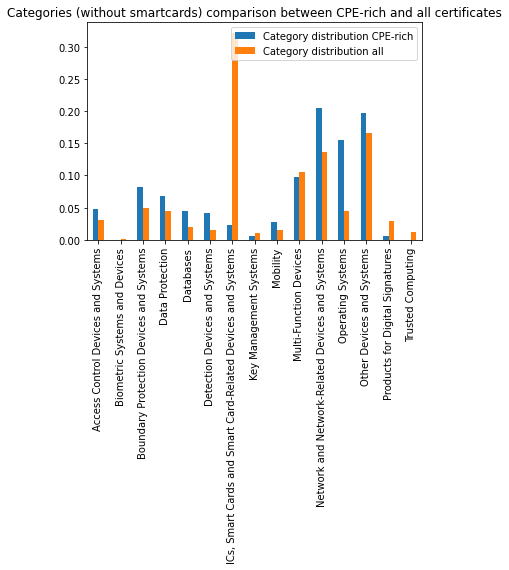

In [21]:
df_filtered = df.loc[~df.verified_cpe_matches.isnull()]
categories_filtered = df_filtered.category.value_counts().sort_index().rename('Category distribution CPE-rich')
categories_all = df.category.value_counts().sort_index().rename('Category distribution all')
categories_merged = pd.concat([categories_filtered, categories_all], axis=1)
categories_merged = categories_merged.div(categories_merged.sum(axis=0), axis=1)
categories_merged.plot.bar(title='Categories (without smartcards) comparison between CPE-rich and all certificates')

In [22]:
# Build CVE dataset
cves = list(itertools.chain.from_iterable([x.heuristics.related_cves for x in dset if x.heuristics.related_cves]))
cve_dset = CVEDataset({x.cve_id: x for x in cves})
cve_df = cve_dset.to_pandas()

## Basic correlations between security level and CVEs

In [23]:
# Introduce highest security level EAL variable
eals = ['EAL1', 'EAL1+', 'EAL2', 'EAL2+', 'EAL3', 'EAL3+', 'EAL4', 'EAL4+', 'EAL5', 'EAL5+', 'EAL6+', 'EAL7', 'EAL7+']
df['highest_security_level'] = df.security_level.map(lambda all_levels: [eal for eal in all_levels if eal.startswith('EAL')] if all_levels else np.nan)
df.highest_security_level = df.highest_security_level.map(lambda x: x[0] if x and isinstance(x, list) else np.nan)
df.highest_security_level = pd.Categorical(df.highest_security_level, categories=eals, ordered=True)

# Get some auxillary columns related to CVEs
df['n_cves'] = df.related_cves.map(lambda x: len(x) if x is not np.nan else 0)
df['cve_ids'] = df.related_cves.map(lambda x: [y.cve_id for y in x] if x is not np.nan else np.nan)
df['cve_published_dates'] = df.related_cves.map(lambda x: [y.published_date.date() for y in x] if x is not np.nan else np.nan)
df['earlierst_cve'] = df.cve_published_dates.map(lambda x: min(x) if isinstance(x, list) else np.nan)

# Get the CVE with the highest base score relevant to a certificate
df['worst_cve'] = df.cve_ids.map(lambda x: max([cve_dset[cve].impact.base_score for cve in x]) if x is not np.nan else np.nan)

# Compute correlation of security level and number of cves
# Only very weak correlation found, higher level => less CVEs, definitely not conclusive, just for our information
print(f'Correlation between security level and number of CVES: {df.highest_security_level.cat.codes.corr(df.n_cves)}')
vuln_rich_df = df.loc[df.n_cves > 0]
print(f'Correlation between security level and number of CVEs (excluding vulnerability-free certs): {vuln_rich_df.highest_security_level.cat.codes.corr(vuln_rich_df.n_cves)}')

# Compute correlation of security level and the base-score of the worst CVE
print(f'Correlation between security level and the worst CVE (excluding vulnerability-free certs): {vuln_rich_df.highest_security_level.cat.codes.corr(df.worst_cve)}')

Correlation between security level and number of CVES: -0.05238258003906801
Correlation between security level and number of CVEs (excluding vulnerability-free certs): -0.07382884968176168
Correlation between security level and the worst CVE (excluding vulnerability-free certs): -0.0654461584763112


## Time from CVE to maintainance update

The following block computes time from CVE to maintenance update of a certificate. Though, it has some limitations:
- So far we only watch for first CVE related to a certified product (though most of certificates have only one maintenance anyway, if they even have one)
- We assume that a maintance update released *after* (by date comparison) CVE fixes that vulnerability
- The sample size is small. Only 36 certificates have at least one CVE and at least one Maintenance update. Out of those, only 23 certificates have maintenance update that comes after a CVE
- Some stats is shown below, the quantiles in the number of days that it takes to fix the CVE are (267, 382, 562)
- Many certificates have some CVE (167) that is not fixed in a form of a maintenance update

In [24]:
def find_earlierst_after_cve(row):
    "Given dataframe row, will return first maintenance date succeeding first published CVE related to a certificate if exists, else np.nan"
    if isinstance(row['earlierst_cve'], float):
        return np.nan
    maintenances_after_cve = list(filter(lambda x: x > row['earlierst_cve'], row['maintenance_dates']))
    return min(maintenances_after_cve) if maintenances_after_cve else np.nan

# Recover number of maintenances
n_maintenances = main_df.groupby('related_cert_digest').name.count()
n_maintenances.index.name = 'dgst'
n_maintenances = n_maintenances.rename('n_maintenances')
df = pd.concat([df, n_maintenances], axis='columns')
df.n_maintenances = df.n_maintenances.fillna(0).astype('int32')

# Compute how many vulnerable certs have 0 or >0 maintenance updates
n_unfixed_certs = df.loc[(df.n_cves>0) & (df.n_maintenances==0)].shape[0]
n_fixed_certs = df.loc[(df.n_cves>0) & (df.n_maintenances>0)].shape[0]
print(f'Number of certificates with >0 CVEs but 0 maintenance reports: {n_unfixed_certs}')
print(f'Number of certificates with >0 CVEs and >0 maintenance reports: {n_fixed_certs}')

# Recover dates of maintenance updates
main_dates = main_df.copy()
main_dates.maintenance_date = main_df.maintenance_date.map(lambda x: [x])
main_dates = main_dates.groupby('related_cert_digest').maintenance_date.agg('sum').rename('maintenance_dates')
main_dates.index.name = 'dgst'
df = pd.concat([df, main_dates], axis='columns')

# Compute earlierst maintenance that comes after some CVE, compute time to fix
df_fixed = df.loc[(df.n_cves > 0) & (df.n_maintenances > 0)].copy()
df_fixed.loc[:, 'earlierst_maintenance'] = df_fixed.apply(find_earlierst_after_cve, axis=1)
df_fixed.loc[:, 'time_to_fix_cve'] = df_fixed.earlierst_maintenance - df_fixed.earlierst_cve

print(df_fixed.time_to_fix_cve)

Number of certificates with >0 CVEs but 0 maintenance reports: 167
Number of certificates with >0 CVEs and >0 maintenance reports: 36
c57b9308028caccf    382 days
b891647233f3f188    430 days
83e595d2b5e3d74f     40 days
634af5acb21aa587         NaT
fc69121b90c093fb    279 days
d832a3b75b62e38d   1103 days
d6a6e613a0dfb5ba    300 days
2755b2c7bdb9bcac         NaT
172856c5954d49f3         NaT
86c6082b2ea2db8c    125 days
2b6a2b0e304555da    264 days
09b43147f1307352    554 days
ce987167d42db722    338 days
fb58cf87032c58ae         NaT
7335557650265c0f         NaT
b596eef2c1eaf110    540 days
281a5288a1cf1261    493 days
9921f5e46c0ee664   2585 days
702a3fe5f10225fc   2249 days
7060f64a78b55baa         NaT
3e8c0381164e725c    571 days
a0f112a821dfe3fe         NaT
570a4f380de9078e    270 days
10121fa1b66acd21    189 days
2564b0bf8d343787    930 days
2fd325a6aae3b9bf     12 days
893be82a6b027186         NaT
6e2aa6a74a044b57         NaT
a182266a61c97e00    545 days
d5ee07f7eae70c42         

In [25]:
df_fixed.loc[~df_fixed.time_to_fix_cve.isnull()]['time_to_fix_cve'].describe()

count                             23
mean     573 days 02:05:13.043478264
std      638 days 10:58:05.806977968
min                 12 days 00:00:00
25%                267 days 00:00:00
50%                382 days 00:00:00
75%                562 days 00:00:00
max               2585 days 00:00:00
Name: time_to_fix_cve, dtype: object